## Setup


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import numpy as np

In [ ]:
cd /content/drive/MyDrive/colab-github/H2GCN/npz-datasets/

/content/drive/MyDrive/colab-github/H2GCN/npz-datasets


In [ ]:
cd syn-cora/

/content/drive/MyDrive/colab-github/H2GCN/npz-datasets/syn-cora


In [ ]:
!pip install torch-scatter -f https://data.pyg.org/whl/torch-1.12.0+cu113.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-1.12.0+cu113.html
!pip install torch-cluster -f https://data.pyg.org/whl/torch-1.12.0+cu113.html
!pip install git+https://github.com/pyg-team/pytorch_geometric.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://data.pyg.org/whl/torch-1.12.0+cu113.html
     |████████████████████████████████| 7.9 MB 3.9 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://data.pyg.org/whl/torch-1.12.0+cu113.html
     |████████████████████████████████| 3.5 MB 3.9 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://data.pyg.org/whl/torch-1.12.0+cu113.html
     |████████████████████████████████| 2.4 MB 4.0 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/pyg-team/pytorch_geometric.git to /tmp/pip-req-build-1v1wpwnk
  Running command git clone -q https://github.com/pyg-team/pytorch_geometric.git /tmp/pip-req-build-1v1wpwnk
  Created wheel for torch-geomet

In [ ]:
import torch
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import math, random, torch, collections, time, torch.nn.functional as F, networkx as nx, matplotlib.pyplot as plt, numpy as np
from torch.nn import Linear
from torch_geometric.nn import GCNConv
from IPython.display import clear_output
from torch_geometric.utils import to_networkx
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from functools import wraps

# Helper function for visualization.
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

def visualize(h, color):
    z = TSNE(n_components=2).fit_transform(out.detach().cpu().numpy())
    plt.figure(figsize=(10,10))
    plt.xticks([])
    plt.yticks([])

    plt.scatter(z[:, 0], z[:, 1], s=70, c=color, cmap="Set2")
    plt.show()

In [ ]:
def visualize_graph(G, color, size=300, epoch=None, loss=None):
    plt.figure(figsize=(7, 7))
    plt.xticks([])
    plt.yticks([])
    nx.draw_networkx(G, pos=nx.spring_layout(G, seed=42), with_labels=False,
                     node_color=color, cmap="Set2", node_size=size)
    plt.show()


def visualize_tsne(out, color, size=30, epoch=None, loss=None):
    z = TSNE(n_components=2).fit_transform(out.detach().cpu().numpy())

    plt.figure(figsize=(7, 7))
    plt.xticks([])
    plt.yticks([])

    plt.scatter(z[:, 0], z[:, 1], s=size, c=color, cmap="Set2")
    if epoch is not None and loss is not None:
        plt.xlabel(f'Epoch: {epoch}, Loss: {loss:.4f}', fontsize=16)
    plt.show()


def visualize_pca(out, color, size=30, epoch=None, loss=None):
    h = PCA(n_components=2).fit_transform(out.detach().cpu().numpy())
    plt.figure(figsize=(7, 7))
    plt.xticks([])
    plt.yticks([])

    plt.scatter(h[:, 0], h[:, 1], s=size, c=color, cmap="Set2")
    if epoch is not None and loss is not None:
        plt.xlabel(f'Epoch: {epoch}, Loss: {loss:.4f}', fontsize=16)
    plt.show()


def delete_undirected_edges(edge_index, p):
    edges = torch.clone(edge_index).t().numpy()
    edges = set(map(frozenset, edges))
    n = len(edges)
    edges = random.sample(edges, round(n * (1 - p)))
    edges = list(map(list, edges))
    reverse_edges = list(map(lambda x: [x[1], x[0]], edges))
    sample = sorted(edges + reverse_edges)
    return torch.tensor(sample).t().contiguous()


def add_undirected_edges(edge_index, edge_num, node_total=2708):
    edges = torch.clone(edge_index).t().numpy()
    edges = set(map(frozenset, edges))
    n = len(edges)
    while len(edges) - n < edge_num:
        edges.add(frozenset(random.sample(range(node_total), 2)))
    edges = list(map(list, edges))
    reverse_edges = list(map(lambda x: [x[1], x[0]], edges))
    sample = sorted(edges + reverse_edges)
    return torch.tensor(sample).t().contiguous()


def dataset_print(dataset):
    print(f'Dataset: {dataset}:')
    print('======================')
    print(f'Number of graphs: {len(dataset)}')
    print(f'Number of features: {dataset.num_features}')
    print(f'Number of classes: {dataset.num_classes}')


def data_print(data):
    print(data)
    print('==============================================================')

    # Gather some statistics about the graph.
    print(f'Number of nodes: {data.num_nodes}')
    print(f'Number of edges: {data.num_edges}')
    print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
    print(f'Number of training nodes: {data.train_mask.sum()}')
    print(f'Training node label rate: {int(data.train_mask.sum()) / data.num_nodes:.2f}')
    print(f'Contains isolated nodes: {data.has_isolated_nodes()}')
    print(f'Contains self-loops: {data.contains_self_loops()}')
    print(f'Is undirected: {data.is_undirected()}')


def timethis(func):
    @wraps(func)
    def wrapper(*args, **kwargs):
        start = time.time()
        result = func(*args, **kwargs)
        end = time.time()
        print("Time to run function '{}': {:.2f} seconds".format(func.__name__, end - start))
        return result

    return wrapper


In [ ]:
from typing import Optional, Tuple
from torch_geometric.typing import Adj, OptTensor, PairTensor

import torch
from torch import Tensor
from torch.nn import Parameter
from torch_scatter import scatter_add
from torch_sparse import SparseTensor, matmul, fill_diag, sum as sparsesum, mul
from torch_geometric.nn.inits import zeros
from torch_geometric.nn.dense.linear import Linear
from torch_geometric.nn.conv import MessagePassing
from torch_geometric.utils import add_remaining_self_loops
from torch_geometric.utils.num_nodes import maybe_num_nodes

from torch_geometric.datasets import WebKB
from torch_geometric.transforms import NormalizeFeatures
import torch
import torch_geometric as tg
import pandas as pd


@torch.jit._overload
def gcn_norm(edge_index, edge_weight=None, num_nodes=None, improved=False,
             add_self_loops=True, dtype=None):
    # type: (Tensor, OptTensor, Optional[int], bool, bool, Optional[int]) -> PairTensor  # noqa
    pass


@torch.jit._overload
def gcn_norm(edge_index, edge_weight=None, num_nodes=None, improved=False,
             add_self_loops=True, dtype=None):
    # type: (SparseTensor, OptTensor, Optional[int], bool, bool, Optional[int]) -> SparseTensor  # noqa
    pass


def gcn_no_norm(edge_index, edge_weight=None, num_nodes=None, improved=False,
                add_self_loops=True, dtype=None):
    fill_value = 2. if improved else 1.

    if isinstance(edge_index, SparseTensor):
        adj_t = edge_index
        if not adj_t.has_value():
            adj_t = adj_t.fill_value(1., dtype=dtype)
        if add_self_loops:
            adj_t = fill_diag(adj_t, fill_value)
        return adj_t

    else:
        num_nodes = maybe_num_nodes(edge_index, num_nodes)

        if edge_weight is None:
            edge_weight = torch.ones((edge_index.size(1),), dtype=dtype,
                                     device=edge_index.device)

        if add_self_loops:
            edge_index, tmp_edge_weight = add_remaining_self_loops(
                edge_index, edge_weight, fill_value, num_nodes)
            assert tmp_edge_weight is not None
            edge_weight = tmp_edge_weight
        return edge_index, edge_weight


def gcn_diffusion(edge_index, edge_weight=None, num_nodes=None, improved=False,
                  add_self_loops=True, dtype=None, alpha=0.5, beta = 1.0):
    fill_value = beta

    if isinstance(edge_index, SparseTensor):
        adj_t = edge_index
        if not adj_t.has_value():
            adj_t = adj_t.fill_value(1., dtype=dtype)
        if add_self_loops:
            adj_t = fill_diag(adj_t, fill_value)
        deg = sparsesum(adj_t, dim=1)  # sum of each row of the sparse tensor
        deg_inv_sqrt = deg.pow_(-alpha)
        deg_inv_sqrt.masked_fill_(deg_inv_sqrt == float('inf'), 0.)  # put 0. where deg_inv_sprt == inf
        adj_t = mul(adj_t, deg_inv_sqrt.view(-1, 1))
        adj_t = mul(adj_t, deg_inv_sqrt.view(1, -1))  #### L_alpha = D^{-alpha}LD^{-alpha}
        deg = sparsesum(adj_t, dim=1)  #### degree D_alpha
        deg_inv = deg.pow_(-1)
        deg_inv.masked_fill_(deg == float('inf'), 0.)
        adj_t = mul(adj_t, deg_inv.view(1, -1))
        if add_self_loops == False:
            adj_t = fill_diag(adj_t, 1.)
        return adj_t

    else:
        num_nodes = maybe_num_nodes(edge_index, num_nodes)

        if edge_weight is None:
            edge_weight = torch.ones((edge_index.size(1),), dtype=dtype,
                                     device=edge_index.device)

        if add_self_loops:
            edge_index, tmp_edge_weight = add_remaining_self_loops(
                edge_index, edge_weight, fill_value, num_nodes)
            assert tmp_edge_weight is not None
            edge_weight = tmp_edge_weight
        row, col = edge_index[0], edge_index[1]
        deg = scatter_add(edge_weight, col, dim=0, dim_size=num_nodes)
        # print(deg)
        deg_inv_sqrt = deg.pow_(-alpha)
        deg_inv_sqrt.masked_fill_(deg_inv_sqrt == float('inf'), 0)
        L = deg_inv_sqrt[row] * edge_weight * deg_inv_sqrt[col]
        # print(scatter_add(L, col, dim=0, dim_size=data.num_nodes))
        deg_alpha = scatter_add(L, row, dim=0, dim_size=num_nodes)
        deg_inv = deg_alpha.pow_(-1)
        deg_inv.masked_fill_(deg == float('inf'), 0)
        L = deg_inv[row] * L
        if add_self_loops == False:
            edge_index, tmp_edge_weight = add_remaining_self_loops(
                edge_index, L, fill_value, num_nodes)
            assert tmp_edge_weight is not None
            L = tmp_edge_weight
        return edge_index, L


def gcn_norm(edge_index, edge_weight=None, num_nodes=None,
             improved=False,
             add_self_loops=True, dtype=None, alpha=0.5, beta = 1.0):
    fill_value = beta

    if isinstance(edge_index, SparseTensor):
        adj_t = edge_index
        if not adj_t.has_value():
            adj_t = adj_t.fill_value(1., dtype=dtype)
        if add_self_loops:
            adj_t = fill_diag(adj_t, fill_value)
        deg = sparsesum(adj_t, dim=1)
        deg_inv_sqrt = deg.pow_(-alpha)
        deg_inv_sqrt.masked_fill_(deg_inv_sqrt == float('inf'), 0.)
        adj_t = mul(adj_t, deg_inv_sqrt.view(-1, 1))
        adj_t = mul(adj_t, deg_inv_sqrt.view(1, -1))
        if add_self_loops == False:
            adj_t = adj_t.fill_value(fill_value, dtype=dtype)
        return adj_t

    else:
        num_nodes = maybe_num_nodes(edge_index, num_nodes)

        if edge_weight is None:
            edge_weight = torch.ones((edge_index.size(1),), dtype=dtype,
                                     device=edge_index.device)

        if add_self_loops:
            edge_index, tmp_edge_weight = add_remaining_self_loops(
                edge_index, edge_weight, fill_value, num_nodes)
            assert tmp_edge_weight is not None
            edge_weight = tmp_edge_weight

        row, col = edge_index[0], edge_index[1]
        deg = scatter_add(edge_weight, col, dim=0, dim_size=num_nodes)
        deg_inv_sqrt = deg.pow_(-alpha)
        deg_inv_sqrt.masked_fill_(deg_inv_sqrt == float('inf'), 0)
        L = deg_inv_sqrt[row] * edge_weight * deg_inv_sqrt[col]
        if add_self_loops == False:
            edge_index, tmp_edge_weight = add_remaining_self_loops(
                edge_index, L, fill_value, num_nodes)
            assert tmp_edge_weight is not None
            L = tmp_edge_weight
        return edge_index, L


def gcn_norm_sym(edge_index, alpha=0.5, beta = 1.0, edge_weight=None, num_nodes=None, improved=False,
                 add_self_loops=True, dtype=None):
    fill_value = beta

    if isinstance(edge_index, SparseTensor):
        adj_t = edge_index
        if not adj_t.has_value():
            adj_t = adj_t.fill_value(1., dtype=dtype)
        if add_self_loops:
            adj_t = fill_diag(adj_t, fill_value)
        deg = sparsesum(adj_t, dim=1)  # sum of each row of the sparse tensor
        deg_inv_sqrt = deg.pow_(-alpha)
        deg_inv_sqrt.masked_fill_(deg_inv_sqrt == float('inf'), 0.)  # put 0. where deg_inv_sprt == inf
        adj_t = mul(adj_t, deg_inv_sqrt.view(-1, 1))
        adj_t = mul(adj_t, deg_inv_sqrt.view(1, -1))  #### L_alpha = D^{-alpha}LD^{-alpha}
        deg = sparsesum(adj_t, dim=1)  #### degree D_alpha
        deg_inv = deg.pow_(-0.5)
        deg_inv.masked_fill_(deg == float('inf'), 0.)
        adj_t = mul(adj_t, deg_inv.view(1, -1))
        adj_t = mul(adj_t, deg_inv.view(-1, 1))
        if add_self_loops == False:
            adj_t = fill_diag(adj_t, 1.)
        return adj_t

    else:
        num_nodes = maybe_num_nodes(edge_index, num_nodes)

        if edge_weight is None:
            edge_weight = torch.ones((edge_index.size(1),), dtype=dtype,
                                     device=edge_index.device)

        if add_self_loops:
            edge_index, tmp_edge_weight = add_remaining_self_loops(
                edge_index, edge_weight, fill_value, num_nodes)
            assert tmp_edge_weight is not None
            edge_weight = tmp_edge_weight
        row, col = edge_index[0], edge_index[1]
        deg = scatter_add(edge_weight, col, dim=0, dim_size=num_nodes)
        # print(deg)
        deg_inv_sqrt = deg.pow_(-alpha)
        deg_inv_sqrt.masked_fill_(deg_inv_sqrt == float('inf'), 0)
        L = deg_inv_sqrt[row] * edge_weight * deg_inv_sqrt[col]
        # print(scatter_add(L, col, dim=0, dim_size=data.num_nodes))
        deg_alpha = scatter_add(L, row, dim=0, dim_size=num_nodes)
        deg_inv = deg_alpha.pow_(-0.5)
        deg_inv.masked_fill_(deg == float('inf'), 0)
        L = deg_inv[row] * L * deg_inv[col]
        if add_self_loops == False:
            edge_index, tmp_edge_weight = add_remaining_self_loops(
                edge_index, L, fill_value, num_nodes)
            assert tmp_edge_weight is not None
            L = tmp_edge_weight
        return edge_index, L


class AggregationScheme(MessagePassing):
    r"""The graph convolutional operator from the `"Semi-supervised
    Classification with Graph Convolutional Networks"
    <https://arxiv.org/abs/1609.02907>`_ paper
    .. math::
        \mathbf{X}^{\prime} = \mathbf{\hat{D}}^{-1/2} \mathbf{\hat{A}}
        \mathbf{\hat{D}}^{-1/2} \mathbf{X} \mathbf{\Theta},
    where :math:`\mathbf{\hat{A}} = \mathbf{A} + \mathbf{I}` denotes the
    adjacency matrix with inserted self-loops and
    :math:`\hat{D}_{ii} = \sum_{j=0} \hat{A}_{ij}` its diagonal degree matrix.
    The adjacency matrix can include other values than :obj:`1` representing
    edge weights via the optional :obj:`edge_weight` tensor.
    Its node-wise formulation is given by:
    .. math::
        \mathbf{x}^{\prime}_i = \mathbf{\Theta} \sum_{j \in \mathcal{N}(v) \cup
        \{ i \}} \frac{e_{j,i}}{\sqrt{\hat{d}_j \hat{d}_i}} \mathbf{x}_j
    with :math:`\hat{d}_i = 1 + \sum_{j \in \mathcal{N}(i)} e_{j,i}`, where
    :math:`e_{j,i}` denotes the edge weight from source node :obj:`j` to target
    node :obj:`i` (default: :obj:`1.0`)
    Args:
        in_channels (int): Size of each input sample, or :obj:`-1` to derive
            the size from the first input(s) to the forward method.
        out_channels (int): Size of each output sample.
        improved (bool, optional): If set to :obj:`True`, the layer computes
            :math:`\mathbf{\hat{A}}` as :math:`\mathbf{A} + 2\mathbf{I}`.
            (default: :obj:`False`)
        cached (bool, optional): If set to :obj:`True`, the layer will cache
            the computation of :math:`\mathbf{\hat{D}}^{-1/2} \mathbf{\hat{A}}
            \mathbf{\hat{D}}^{-1/2}` on first execution, and will use the
            cached version for further executions.
            This parameter should only be set to :obj:`True` in transductive
            learning scenarios. (default: :obj:`False`)
        add_self_loops (bool, optional): If set to :obj:`False`, will not add
            self-loops to the input graph. (default: :obj:`True`)
        normalize (bool, optional): Whether to add self-loops and compute
            symmetric normalization coefficients on the fly.
            (default: :obj:`True`)
        bias (bool, optional): If set to :obj:`False`, the layer will not learn
            an additive bias. (default: :obj:`True`)
        **kwargs (optional): Additional arguments of
            :class:`torch_geometric.nn.conv.MessagePassing`.
    """

    _cached_edge_index: Optional[Tuple[Tensor, Tensor]]
    _cached_adj_t: Optional[SparseTensor]

    def __init__(self, improved: bool = False, cached: bool = False,
                 add_self_loops: bool = True, normalize: bool = True,
                 gnn_type: str = "normal", alpha: float = 0.5,beta: float = 1.0,
                 bias: bool = True, **kwargs):

        kwargs.setdefault('aggr', 'add')
        super(AggregationScheme, self).__init__(**kwargs)

        self.improved = improved
        self.cached = cached
        self.gnn_type = gnn_type
        self.alpha = alpha
        self.beta = beta
        self.add_self_loops = add_self_loops
        self.normalize = normalize

        self._cached_edge_index = None
        self._cached_adj_t = None

    def reset_parameters(self):
        self._cached_edge_index = None
        self._cached_adj_t = None

    def forward(self, x: Tensor, edge_index: Adj,
                edge_weight: OptTensor = None) -> Tensor:
        """"""

        if self.normalize:
            if isinstance(edge_index, Tensor):
                cache = self._cached_edge_index
                if cache is None:
                    if self.gnn_type == "normal":
                        edge_index, edge_weight = gcn_norm(  # yapf: disable
                            edge_index, edge_weight, x.size(self.node_dim),
                            self.improved, self.add_self_loops, alpha = self.alpha, beta = self.beta)
                    elif self.gnn_type == "diffusion":
                        print("here")
                        edge_index, edge_weight = gcn_diffusion(  # yapf: disable
                            edge_index,  edge_weight, x.size(self.node_dim),
                            self.improved, self.add_self_loops, alpha = self.alpha, beta = self.beta)
                    elif self.gnn_type == "symmetric diffusion":
                        print("here")
                        edge_index, edge_weight = gcn_norm_sym(  # yapf: disable
                            edge_index, edge_weight, x.size(self.node_dim),
                            self.improved, self.add_self_loops, alpha = self.alpha, beta = self.beta)
                    else:
                        edge_index, edge_weight = gcn_no_norm(  # yapf: disable
                            edge_index, edge_weight, x.size(self.node_dim),
                            self.improved, self.add_self_loops)
                    if self.cached:
                        self._cached_edge_index = (edge_index, edge_weight)
                else:
                    edge_index, edge_weight = cache[0], cache[1]

            elif isinstance(edge_index, SparseTensor):
                cache = self._cached_adj_t
                if cache is None:
                    if self.gnn_type == "normal":
                        edge_index = gcn_norm(  # yapf: disable
                            edge_index, edge_weight, x.size(self.node_dim),
                            self.improved, self.add_self_loops, alpha = self.alpha, beta = self.beta)
                    elif self.gnn_type == "diffusion":
                        edge_index = gcn_diffusion(  # yapf: disable
                            edge_index,  edge_weight, x.size(self.node_dim),
                            self.improved, self.add_self_loops, alpha = self.alpha, beta = self.beta)
                    elif self.gnn_type == "symmetric diffusion":
                        edge_index = gcn_norm_sym(  # yapf: disable
                            edge_index, edge_weight, x.size(self.node_dim),
                            self.improved, self.add_self_loops, alpha = self.alpha, beta = self.beta)
                    else:
                        edge_index = gcn_no_norm(  # yapf: disable
                            edge_index, edge_weight, x.size(self.node_dim),
                            self.improved, self.add_self_loops)
                    if self.cached:
                        self._cached_adj_t = edge_index
                else:
                    edge_index = cache

        # propagate_type: (x: Tensor, edge_weight: OptTensor)
        out = self.propagate(edge_index, x=x, edge_weight=edge_weight,
                             size=None)

        return out

    def message(self, x_j: Tensor, edge_weight: OptTensor) -> Tensor:
        return x_j if edge_weight is None else edge_weight.view(-1, 1) * x_j

    def message_and_aggregate(self, adj_t: SparseTensor, x: Tensor) -> Tensor:
        return matmul(adj_t, x, reduce=self.aggr)

    def __repr__(self):
        return '{}({}, {})'.format(self.__class__.__name__, 0,
                                   0)


class GCNConv(MessagePassing):
    r"""The graph convolutional operator from the `"Semi-supervised
    Classification with Graph Convolutional Networks"
    <https://arxiv.org/abs/1609.02907>`_ paper
    .. math::
        \mathbf{X}^{\prime} = \mathbf{\hat{D}}^{-1/2} \mathbf{\hat{A}}
        \mathbf{\hat{D}}^{-1/2} \mathbf{X} \mathbf{\Theta},
    where :math:`\mathbf{\hat{A}} = \mathbf{A} + \mathbf{I}` denotes the
    adjacency matrix with inserted self-loops and
    :math:`\hat{D}_{ii} = \sum_{j=0} \hat{A}_{ij}` its diagonal degree matrix.
    The adjacency matrix can include other values than :obj:`1` representing
    edge weights via the optional :obj:`edge_weight` tensor.
    Its node-wise formulation is given by:
    .. math::
        \mathbf{x}^{\prime}_i = \mathbf{\Theta} \sum_{j \in \mathcal{N}(v) \cup
        \{ i \}} \frac{e_{j,i}}{\sqrt{\hat{d}_j \hat{d}_i}} \mathbf{x}_j
    with :math:`\hat{d}_i = 1 + \sum_{j \in \mathcal{N}(i)} e_{j,i}`, where
    :math:`e_{j,i}` denotes the edge weight from source node :obj:`j` to target
    node :obj:`i` (default: :obj:`1.0`)
    Args:
        in_channels (int): Size of each input sample, or :obj:`-1` to derive
            the size from the first input(s) to the forward method.
        out_channels (int): Size of each output sample.
        improved (bool, optional): If set to :obj:`True`, the layer computes
            :math:`\mathbf{\hat{A}}` as :math:`\mathbf{A} + 2\mathbf{I}`.
            (default: :obj:`False`)
        cached (bool, optional): If set to :obj:`True`, the layer will cache
            the computation of :math:`\mathbf{\hat{D}}^{-1/2} \mathbf{\hat{A}}
            \mathbf{\hat{D}}^{-1/2}` on first execution, and will use the
            cached version for further executions.
            This parameter should only be set to :obj:`True` in transductive
            learning scenarios. (default: :obj:`False`)
        add_self_loops (bool, optional): If set to :obj:`False`, will not add
            self-loops to the input graph. (default: :obj:`True`)
        normalize (bool, optional): Whether to add self-loops and compute
            symmetric normalization coefficients on the fly.
            (default: :obj:`True`)
        bias (bool, optional): If set to :obj:`False`, the layer will not learn
            an additive bias. (default: :obj:`True`)
        **kwargs (optional): Additional arguments of
            :class:`torch_geometric.nn.conv.MessagePassing`.
    """

    _cached_edge_index: Optional[Tuple[Tensor, Tensor]]
    _cached_adj_t: Optional[SparseTensor]

    def __init__(self, in_channels: int, out_channels: int,
                 improved: bool = False, cached: bool = False,
                 add_self_loops: bool = True, normalize: bool = True,
                 gnn_type: str = "normal", alpha: float = 0.5,beta: float = 1.0,
                 bias: bool = True,
                 **kwargs):

        kwargs.setdefault('aggr', 'add')
        super(GCNConv, self).__init__(**kwargs)

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.improved = improved
        self.cached = cached
        self.gnn_type = gnn_type
        self.alpha = alpha
        self.beta = beta
        self.add_self_loops = add_self_loops
        self.normalize = normalize

        self._cached_edge_index = None
        self._cached_adj_t = None

        self.lin = Linear(in_channels, out_channels, bias=False)
        torch.nn.init.xavier_normal_(self.lin.weight, gain=0.003)

        if bias:
            self.bias = Parameter(torch.Tensor(out_channels))
        else:
            self.register_parameter('bias', None)

        self.reset_parameters()

    def reset_parameters(self):
        self.lin.reset_parameters()
        zeros(self.bias)
        self._cached_edge_index = None
        self._cached_adj_t = None

    def forward(self, x: Tensor, edge_index: Adj,
                edge_weight: OptTensor = None) -> Tensor:
        """"""

        if self.normalize:
            if isinstance(edge_index, Tensor):
                cache = self._cached_edge_index
                if cache is None:
                    if self.gnn_type == "normal":
                        edge_index, edge_weight = gcn_norm(  # yapf: disable
                            edge_index, edge_weight, x.size(self.node_dim),
                            self.improved, self.add_self_loops, alpha=self.alpha, beta = self.beta)
                    elif self.gnn_type == "diffusion":
                        edge_index, edge_weight = gcn_diffusion(  # yapf: disable
                            edge_index,  edge_weight, x.size(self.node_dim),
                            self.improved, self.add_self_loops, alpha=self.alpha, beta = self.beta)
                    elif self.gnn_type == "symmetric diffusion":
                        edge_index, edge_weight = gcn_norm_sym(  # yapf: disable
                            edge_index, edge_weight, x.size(self.node_dim),
                            self.improved, self.add_self_loops, alpha=self.alpha, beta = self.beta)
                    else:
                        edge_index, edge_weight = gcn_no_norm(  # yapf: disable
                            edge_index, edge_weight, x.size(self.node_dim),
                            self.improved, self.add_self_loops)
                    if self.cached:
                        self._cached_edge_index = (edge_index, edge_weight)
                else:
                    edge_index, edge_weight = cache[0], cache[1]

            elif isinstance(edge_index, SparseTensor):
                cache = self._cached_adj_t
                if cache is None:
                    if self.gnn_type == "normal":
                        edge_index = gcn_norm(  # yapf: disable
                            edge_index, edge_weight, x.size(self.node_dim),
                            self.improved, self.add_self_loops, alpha=self.alpha, beta = self.beta)
                    elif self.gnn_type == "diffusion":
                        edge_index = gcn_diffusion(  # yapf: disable
                            edge_index,edge_weight, x.size(self.node_dim),
                            self.improved, self.add_self_loops, alpha=self.alpha, beta = self.beta)
                    elif self.gnn_type == "symmetric diffusion":
                        edge_index, edge_weight = gcn_norm_sym(  # yapf: disable
                            edge_index, edge_weight, x.size(self.node_dim),
                            self.improved, self.add_self_loops, alpha=self.alpha, beta = self.beta)
                    else:
                        edge_index = gcn_no_norm(  # yapf: disable
                            edge_index, edge_weight, x.size(self.node_dim),
                            self.improved, self.add_self_loops)
                    if self.cached:
                        self._cached_adj_t = edge_index
                else:
                    edge_index = cache

        x = self.lin(x)
        # x2 = self.lin2(x)
        # propagate_type: (x: Tensor, edge_weight: OptTensor)
        out = self.propagate(edge_index, x=x, edge_weight=edge_weight,
                             size=None)

        if self.bias is not None:
            out += self.bias

        return out

    def message(self, x_j: Tensor, edge_weight: OptTensor) -> Tensor:
        return x_j if edge_weight is None else edge_weight.view(-1, 1) * x_j

    def message_and_aggregate(self, adj_t: SparseTensor, x: Tensor) -> Tensor:
        return matmul(adj_t, x, reduce=self.aggr)

    def __repr__(self):
        return '{}({}, {})'.format(self.__class__.__name__, self.in_channels,
                                   self.out_channels)

In [ ]:
mask = collections.namedtuple('mask', ('train', 'test'))  # tuple to store train mask, test mask


def train_one_epoch(model, criterion, optimizer, x, y, train_mask=None):  # x is a dictionary
    model.train()
    out, h = model(**x)
    loss = criterion(out, y) if train_mask is None else criterion(out[train_mask], y[train_mask])
    _, predicted = torch.max(out.detach(), 1)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    model.eval()
    with torch.no_grad():
        if train_mask is None:
            length = len(y)
            accuracy = (predicted == y).sum().item() / length
            misclassified = (predicted != y).numpy()
        else:
            length = len(y[train_mask])
            accuracy = (predicted[train_mask] == y[train_mask].detach()).sum().item() / length
            misclassified = (predicted[train_mask] != y[train_mask]).numpy()

    return out, loss.item(), accuracy, misclassified


def test(model, x, y, test_mask=None):  # x is a dictionary
    model.eval()
    with torch.no_grad():
        out, h = model(**x)
        _, predicted = torch.max(out, 1)
        if test_mask is None:
            length = len(y)
            accuracy = (predicted == y).sum().item() / length
        else:
            length = len(y[test_mask])
            accuracy = (predicted[test_mask] == y[test_mask]).sum().item() / length
    return accuracy, predicted[test_mask].numpy()


def plot_acc(train_acc, test_acc=None, xaxis='epochs', yaxis='accuracy', title='Accuracy plot'):
    plt.xlabel(xaxis)
    plt.ylabel(yaxis)
    if test_acc is not None:
        plt.plot(np.arange(len(train_acc)), train_acc, color='red')
        plt.plot(np.arange(len(test_acc)), test_acc, color='blue')
        plt.legend(['train accuracy', 'test accuracy'], loc='upper right')
    else:
        plt.plot(np.arange(len(train_acc)), train_acc, color='red')
        plt.legend(['train accuracy'], loc='upper right')
    plt.title(title)
    plt.tight_layout()
    plt.show()  # show train_acc and test_acc together


def plot_loss(loss, xaxis='epochs', yaxis='loss', title='Loss plot'):
    plt.xlabel(xaxis)
    plt.ylabel(yaxis)
    plt.plot(np.arange(len(loss)), loss, color='black')
    plt.title(title)
    plt.tight_layout()
    plt.show()


@timethis
def train(epochs, model, criterion, optimizer, x, y, m=mask(None, None),
          plotting=True, scatter_size=30, plotting_freq=5, dim_reduction='pca'):
    dim_reduction_dict = {'pca': visualize_pca, 'tsne': visualize_tsne}
    train_acc_list = []
    test_acc_list = []
    loss_list = []
    for epoch in range(epochs):
        out, loss, train_acc, misclassified = train_one_epoch(model, criterion, optimizer, x, y, m.train)
        model.eval()
        test_acc, predictions = test(model, x, y, m.test)
        train_acc_list.append(train_acc)
        loss_list.append(loss)
        test_acc_list.append(test_acc)
        if plotting:
            if epoch % plotting_freq == 0:
                clear_output(wait=True)
                dim_reduction_dict[dim_reduction](out, color=y, size=scatter_size, epoch=epoch, loss=loss)
    if plotting:
        if m == mask(None, None):
            plot_acc(train_acc_list)
        else:
            plot_acc(train_acc_list, test_acc_list)
        plot_loss(loss_list)
    print("Final test accuracy: {:.2f}".format(test_acc_list[-1]))
    return train_acc_list, test_acc_list, loss_list, misclassified, predictions, out

## Cornell

In [ ]:
dataset = WebKB(root='WebKB', name='Cornell', transform=NormalizeFeatures())
###
print()
print(f'Dataset: {dataset}:')
print('======================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

data = dataset[0]  # Get the first graph object.
cornell = dataset[0]  # Get the first graph object.



Dataset: cornell():
Number of graphs: 1
Number of features: 1703
Number of classes: 5


In [ ]:
from torch.nn import Linear

class GCN(torch.nn.Module):
    def __init__(self, hidden_channels, dropout_rate=0.5,  gnn_type="normal", alpha=0, beta = 1,
                 add_self_loops= True,
                 seed = 12345,
                 bias = True):
        super(GCN, self).__init__()
        torch.manual_seed(seed)
        self.conv1 = GCNConv(dataset.num_features, hidden_channels[0],  
                             gnn_type = gnn_type,
                             alpha = alpha, beta = beta,
                            add_self_loops = add_self_loops,
                            bias = bias)
        self.conv2 = GCNConv(hidden_channels[0], dataset.num_classes,
                            gnn_type = gnn_type,
                            alpha = alpha, beta = beta,
                            add_self_loops = add_self_loops,
                            bias = bias)
        #self.lin1 = Linear(dataset.num_classes, dataset.num_classes)
        self.p = dropout_rate
        self.gnn_type = gnn_type 
        self.alpha = alpha
        self.seed = seed
        self.add_self_loops = add_self_loops = add_self_loops

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=self.p, training=self.training)
        x = self.conv2(x, edge_index)
        h = x
#         x = x.relu()
#         x = self.lin1(x)
        return x, h

model = GCN(hidden_channels=[32])
print(model)

GCN(
  (conv1): GCNConv(1703, 32)
  (conv2): GCNConv(32, 5)
)


In [ ]:
# splitting the data into train and test
random.seed(12345)
train_idx = random.choices(range(0,data.num_nodes), k=int(round(data.num_nodes*0.6,0)))
test_idx = list(set(range(0,data.num_nodes)) - set(train_idx))
data.train_mask = torch.zeros(data.num_nodes, dtype=torch.bool)
data.train_mask[train_idx] = 1
data.test_mask = torch.zeros(data.num_nodes, dtype=torch.bool)
data.test_mask[test_idx] = 1

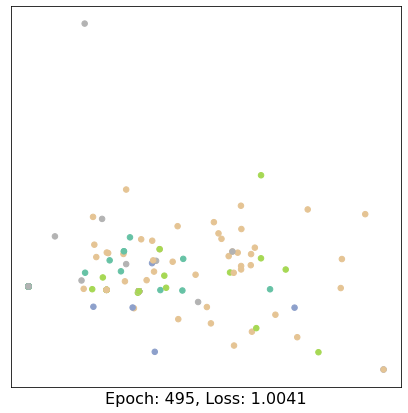

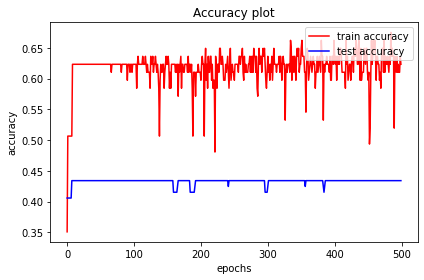

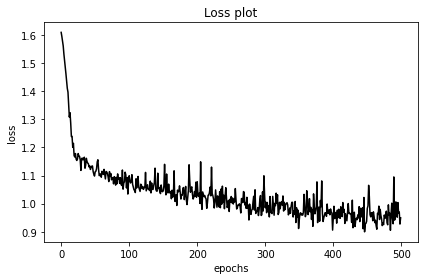

Final test accuracy: 0.43
Time to run function 'train': 10.98 seconds


In [ ]:
n_train = data.train_mask.sum()
n_test = data.test_mask.sum() 
idx = torch.randperm(data.train_mask.shape[0])
train_mask = data.train_mask[idx].view(data.train_mask.size())
test_mask = ~train_mask
idx2  =  (torch.where(test_mask)[0]).numpy()
np.random.shuffle(idx2)
test_mask[idx2[n_test:]] = False

seed = 12345
experiment = 'normal'
beta = 0.0
model = GCN(hidden_channels=[32], gnn_type = experiment, alpha=0.5, beta = 0,
                        seed = seed)
criterion = torch.nn.CrossEntropyLoss() 
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4) #didn't include weight decay

train_acc_list, test_acc_list, loss_list, _,  _ ,_= train(500, model, criterion, optimizer, 
                                         x={'x': data.x, 'edge_index': data.edge_index}, y=data.y, m=mask(train_mask, 
                                                                                                       test_mask),
                                        scatter_size=30, plotting=True)

In [ ]:
n_train = data.train_mask.sum()
n_test = data.test_mask.sum() 
n_exp = 20
results = {}

for i in np.arange(n_exp):
    seed = i
    idx = torch.randperm(data.train_mask.shape[0])
    train_mask = data.train_mask[idx].view(data.train_mask.size())
    test_mask = ~train_mask
    idx2  =  (torch.where(test_mask)[0]).numpy()
    np.random.shuffle(idx2)
    test_mask[idx2[n_test:]] = False
    
    for experiment in ["normal", "diffusion"]:
        for beta in [0.01,0.1,0.2,0.5,0.7,1,2,5,10,50]:
            model = GCN(hidden_channels=[32], gnn_type = experiment, alpha=0.5, beta = beta,
                        seed = seed)
            criterion = torch.nn.CrossEntropyLoss() 
            optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4) #didn't include weight decay

            train_acc_list, test_acc_list, loss_list, _,  _, _ = train(500, model, criterion, optimizer, 
                                                     x={'x': data.x, 'edge_index': data.edge_index}, y=data.y, m=mask(train_mask, 
                                                                                                                   test_mask),
                                                    scatter_size=30, plotting=False)
            results['Cornell_' + experiment + '_' + str(beta) + '_' +  str(i)]  =  {'train_acc': train_acc_list[-1],
                                         'test_acc': test_acc_list[-1],
                                         'seed' : model.seed,
                                         'gnn_type': experiment,
                                       #  'embedding' : out_temp
                                         'exp number': i,
                                        'alpha': 1,
                                        'beta': beta,
                                        'dataset' : 'Cornell'}   
            print(experiment + '_' + str(beta) + '_' +  str(i))

Final test accuracy: 0.48
Time to run function 'train': 2.60 seconds
normal_0.01_0
Final test accuracy: 0.48
Time to run function 'train': 3.51 seconds
normal_0.1_0
Final test accuracy: 0.46
Time to run function 'train': 3.15 seconds
normal_0.2_0
Final test accuracy: 0.47
Time to run function 'train': 2.58 seconds
normal_0.5_0
Final test accuracy: 0.39
Time to run function 'train': 3.34 seconds
normal_0.7_0
Final test accuracy: 0.45
Time to run function 'train': 2.62 seconds
normal_1_0
Final test accuracy: 0.52
Time to run function 'train': 3.20 seconds
normal_2_0
Final test accuracy: 0.59
Time to run function 'train': 2.45 seconds
normal_5_0
Final test accuracy: 0.61
Time to run function 'train': 3.33 seconds
normal_10_0
Final test accuracy: 0.64
Time to run function 'train': 3.37 seconds
normal_50_0
Final test accuracy: 0.56
Time to run function 'train': 3.87 seconds
diffusion_0.01_0
Final test accuracy: 0.56
Time to run function 'train': 3.05 seconds
diffusion_0.1_0
Final test accur

In [ ]:
import pickle

with open('cornell-beta-alpha5.pkl', 'wb') as file:
    # A new file will be created
    pickle.dump(results, file)


In [ ]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import seaborn as sb
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
#from umap import UMAP

## Modify original deg function so that they can have >1 dimensional input
def deg(index, num_nodes: Optional[int] = None,           
        dtype: Optional[torch.dtype] = None):
    r"""Computes the (unweighted) degree of a given one-dimensional index tensor.
    Args:
    index (LongTensor): Index tensor.
    num_nodes (int, optional): The number of nodes, *i.e.*
    :obj:`max_val + 1` of :attr:`index`. (default: :obj:`None`)
    dtype (:obj:`torch.dtype`, optional): The desired data type of the
    returned tensor.\n\n    :rtype: :class:`Tensor`\n    """
    if index.shape[0] != 1: # modify input 
        index = index[0] 
    N = maybe_num_nodes(index, num_nodes)
    out = torch.zeros((N, ), dtype=dtype, device=index.device)
    one = torch.ones((index.size(0), ), dtype=out.dtype, device=out.device)
    return out.scatter_add_(0, index, one)


def tight_acc_plot(res, multiple=False, name='plot.png', interval=[0, 1], symm=True):
    data = pd.DataFrame.from_dict(res).T
    data = data[data['gnn_type'] != 'no']
    if symm == False:
        data = data[data['gnn_type'] != 'symmetric diffusion']
    cmap = sb.diverging_palette(220, 20, as_cmap=True)
    if multiple == False:
        try:
          data1 = data[data['add_self_loop'] == True]
        except KeyError:
          data1 = data
        fig, axes = plt.subplots(1, 1, figsize=(9, 6), sharex=True, sharey=True)
        xticklabels = ['0.01','0.1','0.2','0.5','0.7','1','2','5','10','50']
        sb.set_theme(style='whitegrid')
        my_pal = {'normal': 'red', 'diffusion': 'blue', 'symmetric diffusion': 'green'}
        res = sb.boxplot(data=data1,
                         x='beta',
                         y='test_acc',
                         hue='gnn_type', palette=my_pal)
        res.set_xticklabels(xticklabels, fontsize=25, rotation=0)
        res.set_xlabel(r'$\beta$', fontsize=30)
        res.set_ylabel('Test Accuracy', fontsize=25)
        res.set_ylim(interval)
        fig.tight_layout(rect=[0, 0, .9, 1])
        for tick in axes.xaxis.get_major_ticks():
            tick.label.set_fontsize(25)
        for tick in axes.yaxis.get_major_ticks():
            tick.label.set_fontsize(25)
        axes.legend(title="Convolution", fontsize=20, title_fontsize=20, loc="lower left")
        new_labels = ["Symmetric", "Row-normalized"]
        for t, l in zip(axes.legend_.texts, new_labels):
            t.set_text(l)
        fig.tight_layout()
        # plt.savefig('plot_experiments_betais1_bis.png')
    else:
        fig, axes = plt.subplots(1, 2, figsize=(18, 6), sharex=True, sharey=True)
        xticklabels = ['0',
                       '0.1', '0.2', '0.3', '0.4', '0.5', '0.6', '0.7', '0.8', '0.9', '1']
        sb.set_theme(style='whitegrid')
        my_pal = {'normal': 'red', 'diffusion': 'blue', 'symmetric diffusion': 'green'}
        res = sb.boxplot(data=data[data['add_self_loop'] == True],
                         x='alpha',
                         y='test_acc',
                         hue='gnn_type', palette=my_pal, ax=axes[0])
        res.set_xticklabels(xticklabels, fontsize=25, rotation=0)
        res.set_xlabel(r'$\alpha$', fontsize=30)
        res.set_ylabel('Test Accuracy', fontsize=25)
        res.set_title("With Self-loop", fontsize=20)

        res2 = sb.boxplot(data=data[data['add_self_loop'] == False],
                          x='alpha',
                          y='test_acc',
                          hue='gnn_type', palette=my_pal, ax=axes[1])
        res2.set_xticklabels(xticklabels, fontsize=25, rotation=0)
        res2.set_xlabel(r'$\alpha$', fontsize=30)
        res2.set_ylabel('', fontsize=25)
        res2.set_title("Without Self-loop", fontsize=20)
        fig.tight_layout(rect=[0, 0, .9, 1])

        axes[0].legend(title="Convolution", fontsize=15, title_fontsize=15, loc="lower left")
        axes[1].legend([], [])
        # axes[1].legend(title="Convolution", fontsize = 15, title_fontsize = 15)
        new_labels = ["Symmetric", "Row-normalized", "Symmetric Row-normalized"]
        for i in range(2):
            for tick in axes[i].xaxis.get_major_ticks():
                tick.label.set_fontsize(25)
            for tick in axes[i].yaxis.get_major_ticks():
                tick.label.set_fontsize(25)
            for t, l in zip(axes[i].legend_.texts, new_labels):
                t.set_text(l)

        fig.tight_layout()
    plt.savefig(name)
    plt.show()


In [ ]:
pd.DataFrame.from_dict(results).T

,train_acc,test_acc,seed,gnn_type,exp number,alpha,beta,dataset
Cornell_normal_0.01_0,0.545455,0.377358,0,normal,0,1,0.01,Cornell
Cornell_normal_0.1_0,0.701299,0.386792,0,normal,0,1,0.1,Cornell
Cornell_normal_0.2_0,0.688312,0.377358,0,normal,0,1,0.2,Cornell
Cornell_normal_0.5_0,0.675325,0.40566,0,normal,0,1,0.5,Cornell
Cornell_normal_0.7_0,0.675325,0.424528,0,normal,0,1,0.7,Cornell
...,...,...,...,...,...,...,...,...
Cornell_diffusion_1_29,0.896104,0.669811,29,diffusion,29,1,1,Cornell
Cornell_diffusion_2_29,0.935065,0.679245,29,diffusion,29,1,2,Cornell
Cornell_diffusion_5_29,0.961039,0.754717,29,diffusion,29,1,5,Cornell
Cornell_diffusion_10_29,0.974026,0.764151,29,diffusion,29,1,10,Cornell


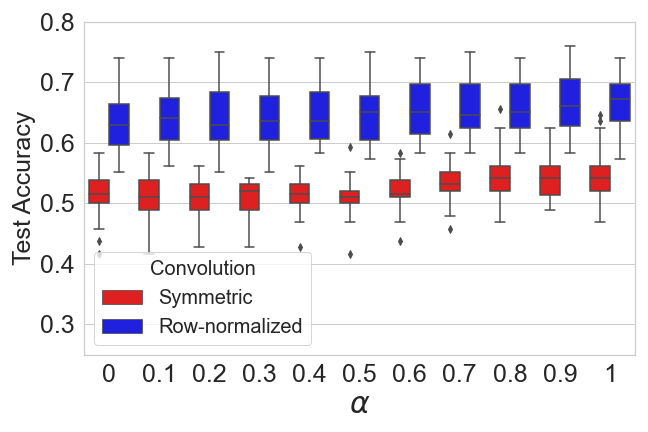

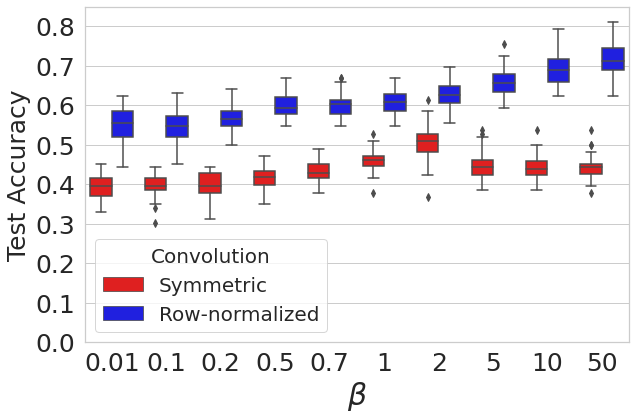

In [ ]:
tight_acc_plot(results, name = 'cornell_accuracy.png',interval=[0,0.85],symm =False, multiple = False) # 7:3

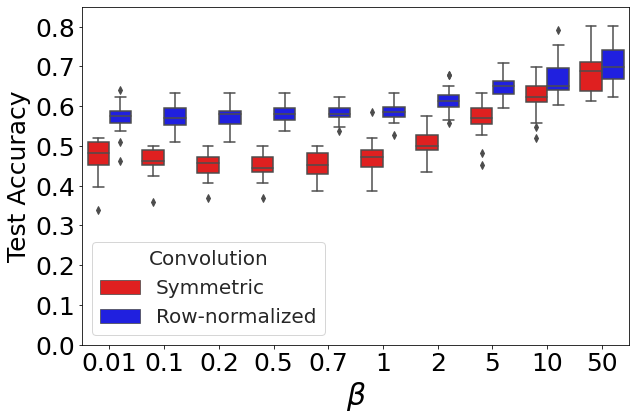

In [ ]:
tight_acc_plot(results, name = 'cornell_accuracy_alpha5.png',interval=[0,0.85],symm =False, multiple = False) # 7:3

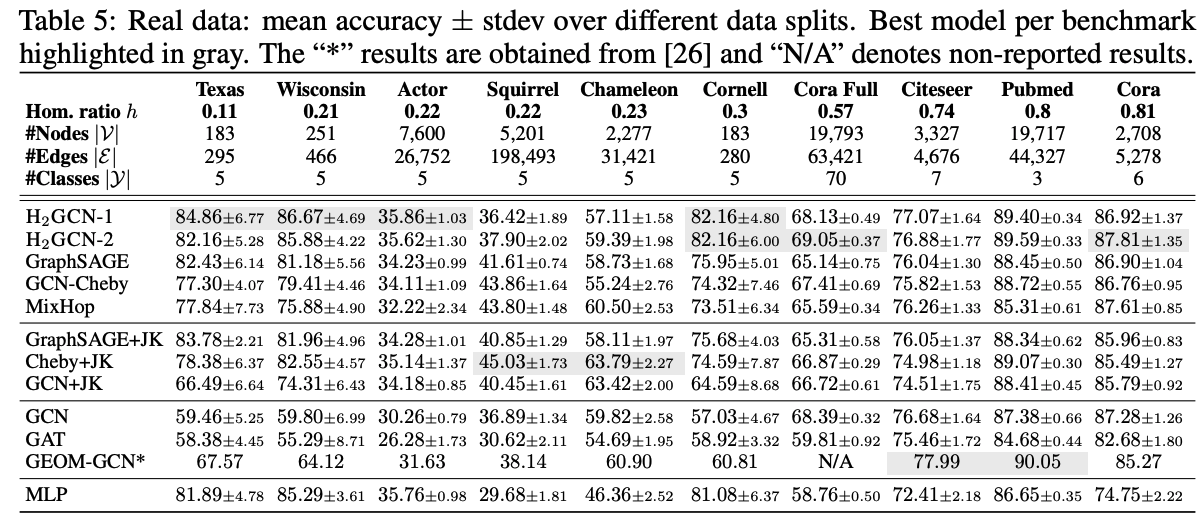

## Actor

In [ ]:
from torch_geometric.datasets import Actor
dataset = Actor(root='WebKB', transform=NormalizeFeatures())
###
print()
print(f'Dataset: {dataset}:')
print('======================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

data = dataset[0]  # Get the first graph object.

print()
print(data)
print('===========================================================================================================')

# Gather some statistics about the graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Number of training nodes: {data.train_mask.sum()}')
print(f'Training node label rate: {int(data.train_mask.sum()) / data.num_nodes:.2f}')
print(f'Contains isolated nodes: {data.has_isolated_nodes()}')
print(f'Contains self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')



###### geometric properties of the dataset
import numpy as np

nodes = {k:  torch.sum(data.edge_index[0,:] ==k).numpy() for k in np.arange(data.x.shape[0])}


Dataset: Actor():
Number of graphs: 1
Number of features: 932
Number of classes: 5

Data(x=[7600, 932], edge_index=[2, 30019], y=[7600], train_mask=[7600, 10], val_mask=[7600, 10], test_mask=[7600, 10])
Number of nodes: 7600
Number of edges: 30019
Average node degree: 3.95
Number of training nodes: 36480
Training node label rate: 4.80
Contains isolated nodes: False
Contains self-loops: True
Is undirected: False


In [ ]:
# splitting the data into train and test
random.seed(12345)
train_idx = random.choices(range(0,data.num_nodes), k=int(round(data.num_nodes*0.7,0)))
test_idx = list(set(range(0,data.num_nodes)) - set(train_idx))
data.train_mask = torch.zeros(data.num_nodes, dtype=torch.bool)
data.train_mask[train_idx] = 1
data.test_mask = torch.zeros(data.num_nodes, dtype=torch.bool)
data.test_mask[test_idx] = 1

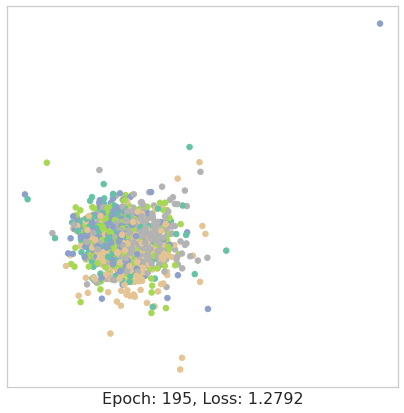

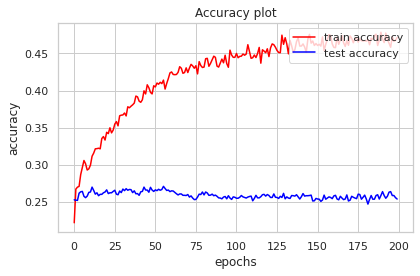

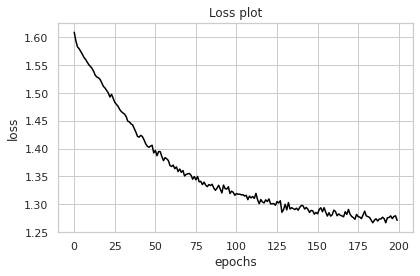

Final test accuracy: 0.25
Time to run function 'train': 26.80 seconds


In [ ]:
n_train = data.train_mask.sum()
n_test = data.test_mask.sum() 
idx = torch.randperm(data.train_mask.shape[0])
train_mask = data.train_mask[idx].view(data.train_mask.size())
test_mask = ~train_mask
idx2  =  (torch.where(test_mask)[0]).numpy()
np.random.shuffle(idx2)
test_mask[idx2[n_test:]] = False

seed = 12345
experiment = 'normal'
beta = 0.1
model = GCN(hidden_channels=[32], gnn_type = experiment, alpha=0.5, beta = beta,
                        seed = seed)
criterion = torch.nn.CrossEntropyLoss() 
optimizer = torch.optim.Adam(model.parameters(), lr=0.02, weight_decay=5e-4) #didn't include weight decay

train_acc_list, test_acc_list, loss_list, _,  _ ,_= train(200, model, criterion, optimizer, 
                                         x={'x': data.x, 'edge_index': data.edge_index}, y=data.y, m=mask(train_mask, 
                                                                                                       test_mask),
                                        scatter_size=30, plotting=True)

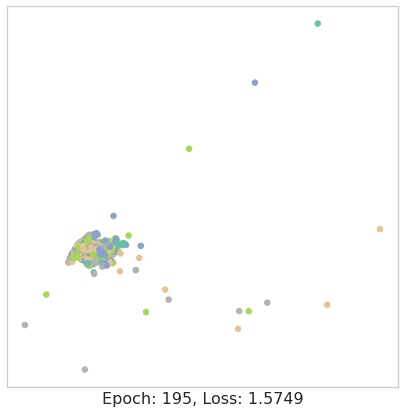

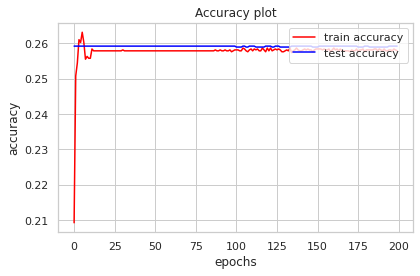

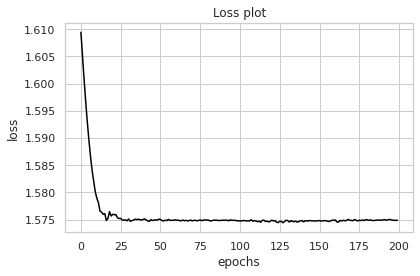

Final test accuracy: 0.26
Time to run function 'train': 20.17 seconds


In [ ]:
n_train = data.train_mask.sum()
n_test = data.test_mask.sum() 
idx = torch.randperm(data.train_mask.shape[0])
train_mask = data.train_mask[idx].view(data.train_mask.size())
test_mask = ~train_mask
idx2  =  (torch.where(test_mask)[0]).numpy()
np.random.shuffle(idx2)
test_mask[idx2[n_test:]] = False

seed = 12345
experiment = 'normal'
beta = 5.0
model = GCN(hidden_channels=[32], gnn_type = experiment, alpha=1.0, beta = beta,
                        seed = seed)
criterion = torch.nn.CrossEntropyLoss() 
optimizer = torch.optim.Adam(model.parameters(), lr=0.02, weight_decay=5e-4) #didn't include weight decay

train_acc_list, test_acc_list, loss_list, _,  _ ,_= train(200, model, criterion, optimizer, 
                                         x={'x': data.x, 'edge_index': data.edge_index}, y=data.y, m=mask(train_mask, 
                                                                                                       test_mask),
                                        scatter_size=30, plotting=True)

In [ ]:
n_train = data.train_mask.sum()
n_test = data.test_mask.sum() 
n_exp = 20
results2 = {}

for i in np.arange(n_exp):
    seed = i
    idx = torch.randperm(data.train_mask.shape[0])
    train_mask = data.train_mask[idx].view(data.train_mask.size())
    test_mask = ~train_mask
    idx2  =  (torch.where(test_mask)[0]).numpy()
    np.random.shuffle(idx2)
    test_mask[idx2[n_test:]] = False
    
    for experiment in ["normal", "diffusion"]:
        for beta in [0.01,0.1,0.2,0.5,0.7,1,2,5,10,50]:
            model = GCN(hidden_channels=[32], gnn_type = experiment, alpha=0.5, beta = beta,
                        seed = seed)
            criterion = torch.nn.CrossEntropyLoss() 
            optimizer = torch.optim.Adam(model.parameters(), lr=0.02, weight_decay=5e-4) #didn't include weight decay

            train_acc_list, test_acc_list, loss_list, _,  _, out_tmp = train(200, model, criterion, optimizer, 
                                                     x={'x': data.x, 'edge_index': data.edge_index}, y=data.y, m=mask(train_mask, 
                                                                                                                   test_mask),
                                                    scatter_size=30, plotting=False)
            results2['Actor_' + experiment + '_' + str(beta) + '_' +  str(i)]  =  {'train_acc': train_acc_list[-1],
                                         'test_acc': test_acc_list[-1],
                                         'seed' : model.seed,
                                         'gnn_type': experiment,
                                         'embedding' : out_tmp,
                                         'exp number': i,
                                        'alpha': 0.5,
                                        'beta': beta,
                                        'dataset' : 'Actor'}   
            print(experiment + '_' + str(beta) + '_' +  str(i))

Final test accuracy: 0.24
Time to run function 'train': 11.31 seconds
normal_0.01_0
Final test accuracy: 0.26
Time to run function 'train': 11.11 seconds
normal_0.1_0
Final test accuracy: 0.26
Time to run function 'train': 11.47 seconds
normal_0.2_0
Final test accuracy: 0.27
Time to run function 'train': 13.30 seconds
normal_0.5_0
Final test accuracy: 0.28
Time to run function 'train': 11.88 seconds
normal_0.7_0
Final test accuracy: 0.28
Time to run function 'train': 11.20 seconds
normal_1_0
Final test accuracy: 0.30
Time to run function 'train': 11.20 seconds
normal_2_0
Final test accuracy: 0.33
Time to run function 'train': 11.19 seconds
normal_5_0
Final test accuracy: 0.34
Time to run function 'train': 11.19 seconds
normal_10_0
Final test accuracy: 0.36
Time to run function 'train': 11.19 seconds
normal_50_0
Final test accuracy: 0.26
Time to run function 'train': 11.37 seconds
diffusion_0.01_0
Final test accuracy: 0.28
Time to run function 'train': 11.26 seconds
diffusion_0.1_0
Fina

In [ ]:
pd.DataFrame.from_dict(results2).T

,train_acc,test_acc,seed,gnn_type,embedding,exp number,alpha,beta,dataset
Actor_normal_0.01_0,0.287329,0.248419,0,normal,"[[tensor(-0.5257, grad_fn=<UnbindBackward0>), ...",0,1,0.01,Actor
Actor_normal_0.1_0,0.462408,0.256059,0,normal,"[[tensor(3.6746, grad_fn=<UnbindBackward0>), t...",0,1,0.1,Actor
Actor_normal_0.2_0,0.483176,0.254478,0,normal,"[[tensor(6.1515, grad_fn=<UnbindBackward0>), t...",0,1,0.2,Actor
Actor_normal_0.5_0,0.459779,0.265806,0,normal,"[[tensor(-0.3300, grad_fn=<UnbindBackward0>), ...",0,1,0.5,Actor
Actor_normal_0.7_0,0.438223,0.271865,0,normal,"[[tensor(-0.3007, grad_fn=<UnbindBackward0>), ...",0,1,0.7,Actor
...,...,...,...,...,...,...,...,...,...
Actor_diffusion_1_29,0.470557,0.326396,29,diffusion,"[[tensor(-0.7571, grad_fn=<UnbindBackward0>), ...",29,1,1,Actor
Actor_diffusion_2_29,0.482387,0.337724,29,diffusion,"[[tensor(-0.8665, grad_fn=<UnbindBackward0>), ...",29,1,2,Actor
Actor_diffusion_5_29,0.504995,0.358008,29,diffusion,"[[tensor(-0.8031, grad_fn=<UnbindBackward0>), ...",29,1,5,Actor
Actor_diffusion_10_29,0.522082,0.362487,29,diffusion,"[[tensor(-0.9071, grad_fn=<UnbindBackward0>), ...",29,1,10,Actor


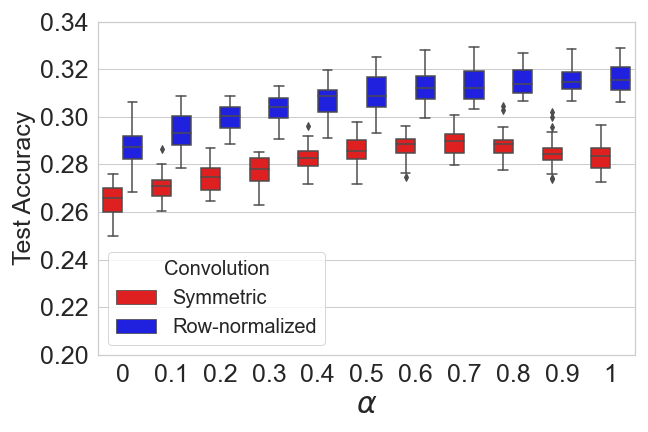

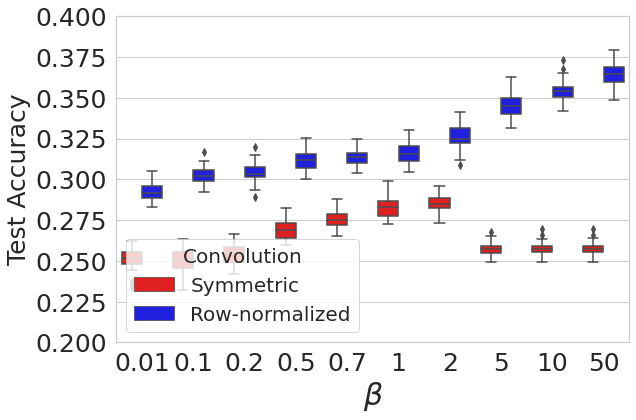

In [ ]:
tight_acc_plot(results2, name = 'actor_accuracy.png',interval=[0.2,0.4],symm =False, multiple = False) # 7:3

In [ ]:
tight_acc_plot(results2, name = 'actor_accuracy_alpha5.png',interval=[0,0.85],symm =False, multiple = False) # 7:3

In [ ]:
import pickle

# Store data 
with open('actor-beta-alpha5.pkl', 'wb') as file:
    # A new file will be created
    pickle.dump(results2, file)

# Cora


In [ ]:
from torch_geometric.datasets import Planetoid
dataset = Planetoid(root='Planetoid',name = 'Cora', transform=NormalizeFeatures())
###
print()
print(f'Dataset: {dataset}:')
print('======================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

data = dataset[0]  # Get the first graph object.

print()
print(data)
print('===========================================================================================================')

# Gather some statistics about the graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Number of training nodes: {data.train_mask.sum()}')
print(f'Training node label rate: {int(data.train_mask.sum()) / data.num_nodes:.2f}')
print(f'Contains isolated nodes: {data.has_isolated_nodes()}')
print(f'Contains self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')



###### geometric properties of the dataset
import numpy as np

nodes = {k:  torch.sum(data.edge_index[0,:] ==k).numpy() for k in np.arange(data.x.shape[0])}

Processing...
Done!



Dataset: Cora():
Number of graphs: 1
Number of features: 1433
Number of classes: 7

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])
Number of nodes: 2708
Number of edges: 10556
Average node degree: 3.90
Number of training nodes: 140
Training node label rate: 0.05
Contains isolated nodes: False
Contains self-loops: False
Is undirected: True


In [ ]:
from torch.nn import Linear

class GCN(torch.nn.Module):
    def __init__(self, hidden_channels, dropout_rate=0.5,  gnn_type="normal", alpha=0, beta = 1,
                 add_self_loops= True,
                 seed = 12345,
                 bias = True):
        super(GCN, self).__init__()
        torch.manual_seed(seed)
        self.conv1 = GCNConv(dataset.num_features, hidden_channels[0],  
                             gnn_type = gnn_type,
                             alpha = alpha, beta = beta,
                            add_self_loops = add_self_loops,
                            bias = bias)
        self.conv2 = GCNConv(hidden_channels[0], dataset.num_classes,
                            gnn_type = gnn_type,
                            alpha = alpha, beta = beta,
                            add_self_loops = add_self_loops,
                            bias = bias)
        #self.lin1 = Linear(dataset.num_classes, dataset.num_classes)
        self.p = dropout_rate
        self.gnn_type = gnn_type 
        self.alpha = alpha
        self.seed = seed
        self.add_self_loops = add_self_loops = add_self_loops

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=self.p, training=self.training)
        x = self.conv2(x, edge_index)
        h = x
#         x = x.relu()
#         x = self.lin1(x)
        return x, h

model = GCN(hidden_channels=[32])
print(model)

GCN(
  (conv1): GCNConv(1433, 32)
  (conv2): GCNConv(32, 7)
)


In [ ]:
# splitting the data into train and test
random.seed(12345)
train_idx = random.choices(range(0,data.num_nodes), k=int(round(data.num_nodes*0.7,0)))
test_idx = list(set(range(0,data.num_nodes)) - set(train_idx))
data.train_mask = torch.zeros(data.num_nodes, dtype=torch.bool)
data.train_mask[train_idx] = 1
data.test_mask = torch.zeros(data.num_nodes, dtype=torch.bool)
data.test_mask[test_idx] = 1

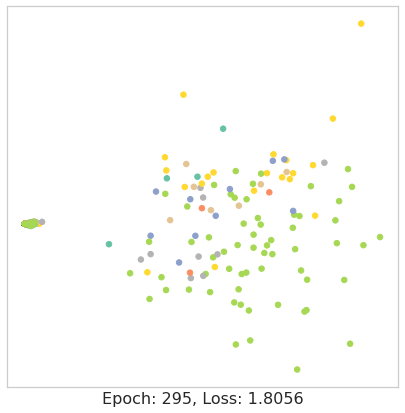

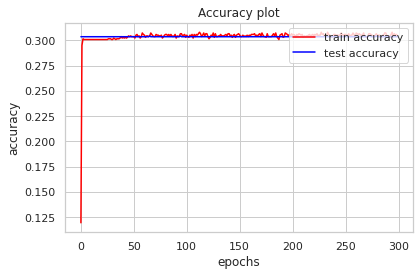

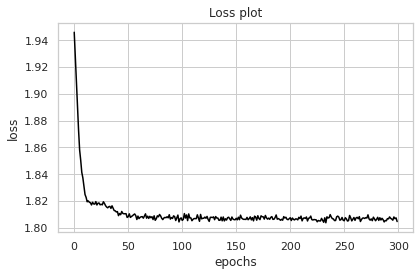

Final test accuracy: 0.30
Time to run function 'train': 18.77 seconds


In [ ]:
n_train = data.train_mask.sum()
n_test = data.test_mask.sum() 
idx = torch.randperm(data.train_mask.shape[0])
train_mask = data.train_mask[idx].view(data.train_mask.size())
test_mask = ~train_mask
idx2  =  (torch.where(test_mask)[0]).numpy()
np.random.shuffle(idx2)
test_mask[idx2[n_test:]] = False

seed = 12345
experiment = 'normal'
beta = 0.0
model = GCN(hidden_channels=[32], gnn_type = experiment, alpha=5.0, beta = 0,
                        seed = seed)
criterion = torch.nn.CrossEntropyLoss() 
optimizer = torch.optim.Adam(model.parameters(), lr=0.05, weight_decay=5e-4) #didn't include weight decay

train_acc_list, test_acc_list, loss_list, _,  _ ,_= train(300, model, criterion, optimizer, 
                                         x={'x': data.x, 'edge_index': data.edge_index}, y=data.y, m=mask(train_mask, 
                                                                                                       test_mask),
                                        scatter_size=30, plotting=True)

In [ ]:
n_train = data.train_mask.sum()
n_test = data.test_mask.sum() 
n_exp = 30
results2 = {}

for i in np.arange(n_exp):
    seed = i
    idx = torch.randperm(data.train_mask.shape[0])
    train_mask = data.train_mask[idx].view(data.train_mask.size())
    test_mask = ~train_mask
    idx2  =  (torch.where(test_mask)[0]).numpy()
    np.random.shuffle(idx2)
    test_mask[idx2[n_test:]] = False
    
    for experiment in ["normal", "diffusion"]:
        for beta in [0.01,0.1,0.2,0.5,0.7,1,2,5,10,50]:
            model = GCN(hidden_channels=[32], gnn_type = experiment, alpha=0.5, beta = beta,
                        seed = seed)
            criterion = torch.nn.CrossEntropyLoss() 
            optimizer = torch.optim.Adam(model.parameters(), lr=0.05, weight_decay=5e-4) #didn't include weight decay

            train_acc_list, test_acc_list, loss_list, _,  _, out_temp = train(300, model, criterion, optimizer, 
                                                     x={'x': data.x, 'edge_index': data.edge_index}, y=data.y, m=mask(train_mask, 
                                                                                                                   test_mask),
                                                    scatter_size=30, plotting=False)
            results2['Cora_' + experiment + '_' + str(beta) + '_' +  str(i)]  =  {'train_acc': train_acc_list[-1],
                                         'test_acc': test_acc_list[-1],
                                         'seed' : model.seed,
                                         'gnn_type': experiment,
                                         'embedding' : out_temp,
                                         'exp number': i,
                                        'alpha': 0.5,
                                        'beta': beta,
                                        'dataset' : 'Cora'}   
            print(experiment + '_' + str(beta) + '_' +  str(i))

Final test accuracy: 0.86
Time to run function 'train': 5.59 seconds
normal_0.01_0
Final test accuracy: 0.87
Time to run function 'train': 6.11 seconds
normal_0.1_0
Final test accuracy: 0.88
Time to run function 'train': 5.87 seconds
normal_0.2_0
Final test accuracy: 0.88
Time to run function 'train': 5.63 seconds
normal_0.5_0
Final test accuracy: 0.88
Time to run function 'train': 6.55 seconds
normal_0.7_0
Final test accuracy: 0.87
Time to run function 'train': 7.02 seconds
normal_1_0
Final test accuracy: 0.87
Time to run function 'train': 6.69 seconds
normal_2_0
Final test accuracy: 0.86
Time to run function 'train': 6.22 seconds
normal_5_0
Final test accuracy: 0.84
Time to run function 'train': 5.40 seconds
normal_10_0
Final test accuracy: 0.79
Time to run function 'train': 5.39 seconds
normal_50_0
Final test accuracy: 0.86
Time to run function 'train': 5.60 seconds
diffusion_0.01_0
Final test accuracy: 0.86
Time to run function 'train': 5.57 seconds
diffusion_0.1_0
Final test accur

In [ ]:
pd.DataFrame.from_dict(results).T

,train_acc,test_acc,seed,gnn_type,embedding,exp number,alpha,beta,dataset
Cora_normal_0.01_0,0.344604,0.330046,0,normal,"[[tensor(-0.0677, grad_fn=<UnbindBackward0>), ...",0,1,0.01,Cora
Cora_normal_0.1_0,0.339568,0.330046,0,normal,"[[tensor(-0.1115, grad_fn=<UnbindBackward0>), ...",0,1,0.1,Cora
Cora_normal_0.2_0,0.334532,0.330046,0,normal,"[[tensor(-0.0809, grad_fn=<UnbindBackward0>), ...",0,1,0.2,Cora
Cora_normal_0.5_0,0.307194,0.312595,0,normal,"[[tensor(-0.0363, grad_fn=<UnbindBackward0>), ...",0,1,0.5,Cora
Cora_normal_0.7_0,0.295683,0.308042,0,normal,"[[tensor(-0.0079, grad_fn=<UnbindBackward0>), ...",0,1,0.7,Cora
...,...,...,...,...,...,...,...,...,...
Cora_diffusion_1_29,0.917266,0.885432,29,diffusion,"[[tensor(-1.2341, grad_fn=<UnbindBackward0>), ...",29,1,1,Cora
Cora_diffusion_2_29,0.92446,0.883915,29,diffusion,"[[tensor(-1.4491, grad_fn=<UnbindBackward0>), ...",29,1,2,Cora
Cora_diffusion_5_29,0.930216,0.882398,29,diffusion,"[[tensor(-3.0130, grad_fn=<UnbindBackward0>), ...",29,1,5,Cora
Cora_diffusion_10_29,0.941727,0.864188,29,diffusion,"[[tensor(-2.2044, grad_fn=<UnbindBackward0>), ...",29,1,10,Cora


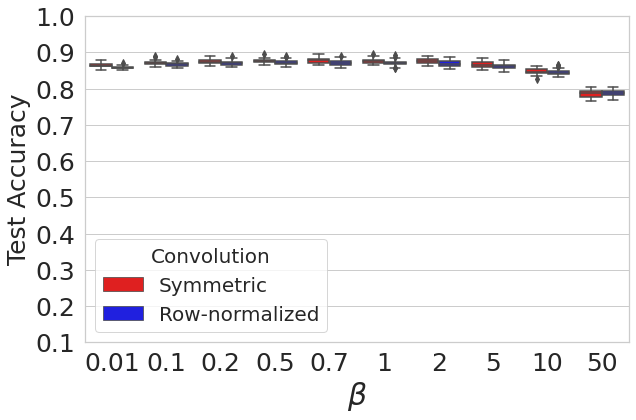

In [ ]:
tight_acc_plot(results2, name = 'cora_accuracy.png',interval=[0.1,1],symm =False, multiple = False) # alpha = 0.5

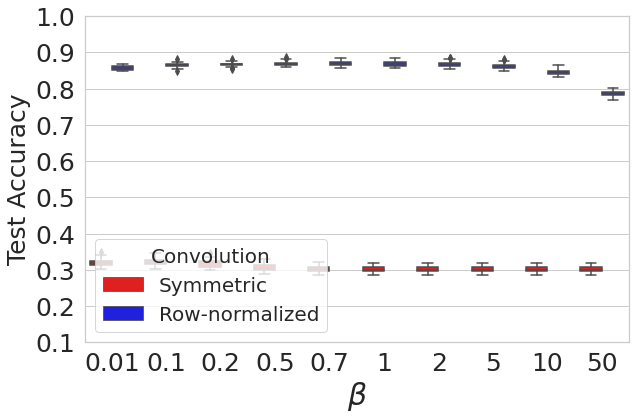

In [ ]:
tight_acc_plot(results, name = 'cora_accuracy.png',interval=[0.1,1],symm =False, multiple = False) # 7:3

In [ ]:
import pickle

# Store data 
#with open('cora-beta.pkl', 'wb') as file:
#    # A new file will be created
#    pickle.dump(results, file)

with open('cora-beta-alpha5.pkl', 'wb') as file:
    # A new file will be created
    pickle.dump(results2, file)

# Load data (deserialize)
#with open('filename.pickle', 'rb') as handle:
#    unserialized_data = pickle.load(handle)

# print(your_data == unserialized_data)